In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df1 = pd.read_csv('subscribers_1.csv', sep=',')
print(df1.shape)
df1.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,1
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,1
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


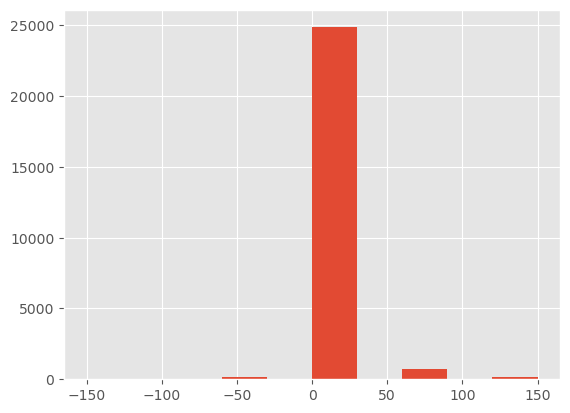

In [3]:
df1['diff_duration'] = df1['new_duration_days'] - df1['last_duration_days']
df1['diff_duration'].hist();

In [4]:
x = df1.query('group == 1')['diff_duration']
y = df1.query('group == 0')['diff_duration']

In [5]:
def asy_mean_test(mean_hat, std_hat, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - sts.norm().cdf(np.abs(z_obs)))
        z_crit = sts.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = sts.norm().cdf(z_obs)
        z_crit = sts.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - sts.norm().cdf(z_obs)
        z_crit = sts.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = sts.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = sts.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

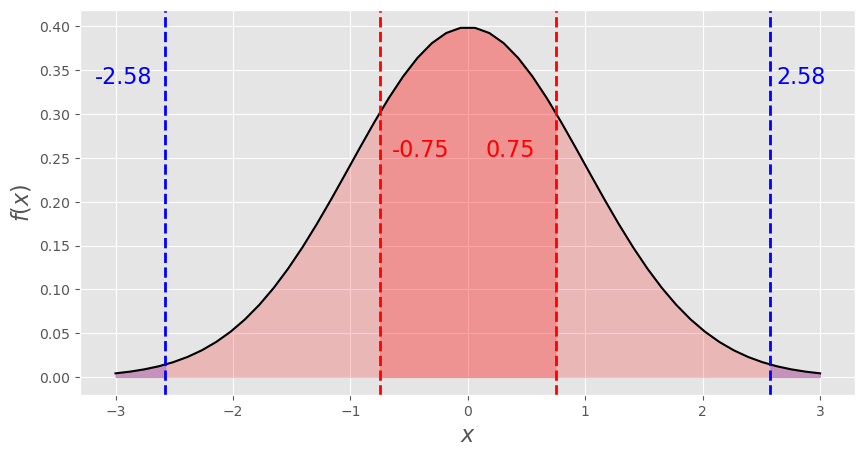

In [6]:
nx, ny = x.size, y.size
diff = x.mean() - y.mean()
diff_std = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/ny)
z_o = diff/diff_std
pv = asy_mean_test(diff, diff_std, mu_0=0, alpha=0.01)

In [7]:
z_obs, pvalue = z_o, pv

In [8]:
df2 = pd.read_csv('subscribers_2.csv', sep=',')
print(df2.shape)
df2.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,new_group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,2
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,2
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


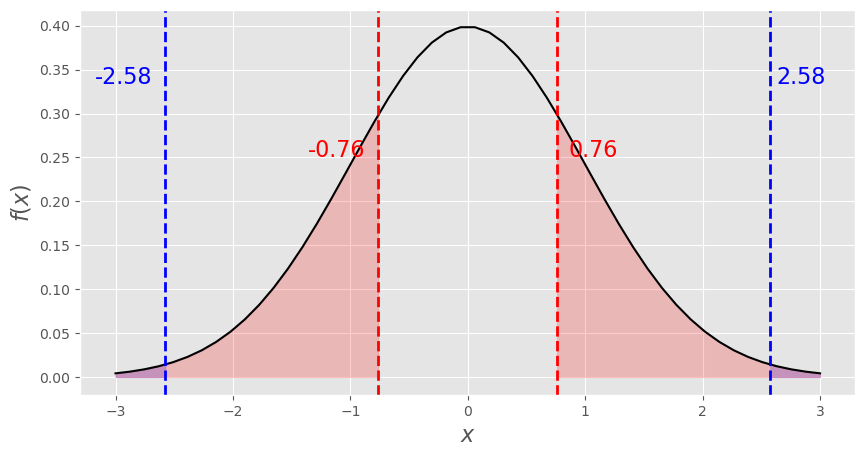

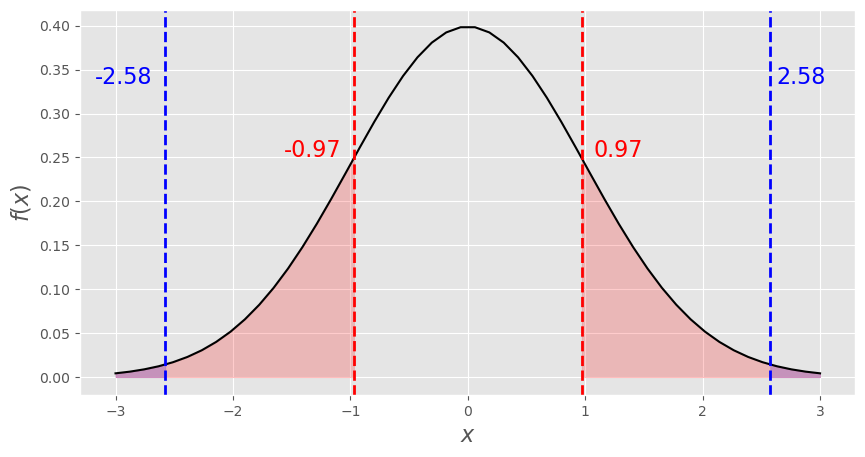

In [9]:
df2['diff_duration'] = df2['new_duration_days'] - df2['last_duration_days']
x = df2.query('new_group == 2')['diff_duration']
y = df2.query('new_group == 0')['diff_duration']
z = df2.query('new_group == 1')['diff_duration']

nx, ny, nz = x.size, y.size, z.size
diff1 = x.mean() - y.mean()
diff2 = x.mean() - z.mean()
diff_std1 = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/ny)
diff_std2 = np.sqrt(x.var(ddof=1)/nx + z.var(ddof=1)/nz)
z_obs1 = diff1/diff_std1
z_obs2 = diff2/diff_std2
pv1 = asy_mean_test(diff1, diff_std1, mu_0=0, alpha=0.01)
pv2 = asy_mean_test(diff2, diff_std2, mu_0=0, alpha=0.01)

In [10]:
from statsmodels.sandbox.stats.multicomp import multipletests

pval_1 = pv1
pval_2 = pv2
pvalue = np.array([pv1, pv2])
rejected, p_corrected, _, _ = multipletests(pvalue, 
                                            alpha = 0.05, 
                                            method = 'holm') 
hyp_cnt = (p_corrected < 0.01).sum()